In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    ZeroPadding2D,
    LeakyReLU,
    UpSampling2D,
    Conv2D,
    Convolution2D,
    MaxPooling2D,
    Concatenate,
    GaussianNoise,
    GaussianDropout,
    Lambda,
    GlobalAveragePooling2D,
)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import h5py
import pickle
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pathlib
from pathlib import Path

import time

import math

In [2]:
print("Tensorflow version: ", tf.version.VERSION)  # tf2
print("Keras version: ", tf.keras.__version__)  # 2.2.4-tf

# tf.enable_eager_execution()  # tf2
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.config.list_physical_devices("GPU"))  # tf2

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path_all_tfrecord = "fp56.tfrecord"

path_train_tfrecord = "fp56_train.tfrecord"
path_test_tfrecord = "fp56_test.tfrecord"

# model save dir

In [4]:
dir_model = "vgg_cam/"
pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [5]:
fp_dim = (56, 56, 6)


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            fp_dim, tf.float32, default_value=tf.zeros(fp_dim, tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "year": tf.io.FixedLenFeature([], tf.int64, default_value=-1),  # 0~9
        # "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        # "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        # "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        # "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    return parsed_example["floorplan"], parsed_example["year"]

In [6]:
def create_dataset(filepath):
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=4)

    ### preprocess the features

    # won't use it. use sparse_categorical_crossentropy instead of categorical_crossentropy.
    #     dataset = dataset.map(_onehot_year, num_parallel_calls=4)

    return dataset

In [7]:
def VGG16_convolutions():
    if K.image_data_format() == "channels_last":
        input_shape = (fp_dim[0], fp_dim[1], fp_dim[2])
    else:
        input_shape = (fp_dim[2], fp_dim[0], fp_dim[1])

    model = Sequential()
    model.add(
        Conv2D(
            64,
            (3, 3),
            activation="relu",
            name="conv1_1",
            padding="same",
            input_shape=input_shape,
        )
    )
    model.add(Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(1, 1), padding="same"))

    model.add(Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", name="conv2_2", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(1, 1), padding="same"))

    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_1", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_2", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_3", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_1", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_2", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_3", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_1", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_2", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_3", padding="same"))
    return model

In [8]:
num_classes = 10


def create_model():
    model = VGG16_convolutions()

    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

# load

In [9]:
df = pd.read_csv("vgg_5y_prediction.csv", index_col=0)
df

,ID,true,prediction
0,8928_160,6,6
1,8928_183,6,6
2,8928_201A,6,7
3,8928_204B,6,6
4,960_35,2,3
...,...,...,...
50407,115454_21D,9,8
50408,115454_34E,9,9
50409,115454_36B,9,9
50410,115454_37A,9,9


In [10]:
predictions = df.prediction.to_numpy()
predictions

array([6, 6, 7, ..., 9, 9, 9])

In [11]:
year_true = df.true.to_numpy()
year_true

array([6, 6, 6, ..., 9, 9, 9])

In [12]:
ids = df.ID.tolist()
ids[:10]

['8928_160',
 '8928_183',
 '8928_201A',
 '8928_204B',
 '960_35',
 '960_41',
 '960_45',
 '960_49F',
 '960_50S',
 '960_53']

In [13]:
df_true = df[df.true == df.prediction]
df_true

,ID,true,prediction
0,8928_160,6,6
1,8928_183,6,6
3,8928_204B,6,6
5,960_41,2,2
13,1289_42,2,2
...,...,...,...
50406,105883_109B,8,8
50408,115454_34E,9,9
50409,115454_36B,9,9
50410,115454_37A,9,9


# run

In [14]:
model = create_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 56, 56, 64)        3520      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       2

In [16]:
# model-12-1.23.hdf5 - loss: 1.2337 - accuracy: 0.5033 - train accuracy: 0.5749
# model-14-1.27.hdf5 - loss: 1.2704 - accuracy: 0.5168 - train accuracy: 0.6033
# model-16-1.35.hdf5 - loss: 1.3514 - accuracy: 0.5331 - train accuracy: 0.6455 #########

path_best = dir_model + "model-16-1.35.hdf5"
path_best

'vgg_cam/model-16-1.35.hdf5'

In [17]:
model.load_weights(path_best)

In [18]:
# Get the 512 input weights to the softmax.
class_weights = model.layers[-1].get_weights()[0]

In [19]:
class_weights.shape

(512, 10)

In [20]:
class_weights.mean(), class_weights.std()

(-0.00032434263, 0.11030664)

In [21]:
# bias for 10 of 5-year classes
model.layers[-1].get_weights()[1]

array([-0.32224256, -0.22646117, -0.20837353,  0.02055918,  0.16211072,
        0.12320401,  0.16629513,  0.05436507,  0.13303962,  0.09750742],
      dtype=float32)

# global average pool output

In [22]:
all_dataset = create_dataset(path_all_tfrecord).batch(64)

In [23]:
gap_model = Model(inputs=model.input, outputs=model.layers[-2].output)

In [24]:
gap_outputs = gap_model.predict(all_dataset, verbose=1)

    788/Unknown - 285s 361ms/step

In [25]:
gap_outputs.mean(), gap_outputs.std()

(0.38606223, 0.3755486)

In [26]:
df_conv = pd.DataFrame(gap_outputs)
df_conv

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.966398,0.259215,0.496319,0.829589,0.344971,0.152670,0.720227,0.123976,0.561715,0.145842,...,0.254680,0.074142,0.570047,0.232208,0.526616,0.675230,0.223346,0.521280,0.677738,0.450698
1,0.524723,0.228454,0.705758,1.030062,0.242494,0.159847,0.409182,0.338511,0.290713,0.317818,...,0.272259,0.100923,0.280092,0.534085,0.604216,0.576146,0.129164,0.130303,0.485668,1.307134
2,1.272955,0.184814,0.463519,0.565227,0.172655,0.276625,0.598416,0.225091,0.263578,0.026571,...,0.083493,0.186316,0.201911,0.370688,0.037566,0.932514,0.232672,0.204352,0.666961,0.746583
3,0.783375,0.118536,0.475350,1.022621,0.323562,0.108109,0.888962,0.225075,0.702394,0.334535,...,0.156285,0.014383,0.275621,0.292180,1.042650,0.312549,0.133560,0.272857,0.833340,0.700633
4,0.302331,0.236494,0.248639,0.066658,0.118952,1.110745,0.212257,0.291952,0.428354,0.617738,...,0.731952,0.417375,0.193406,0.881328,0.180661,0.264903,0.075087,0.708249,0.207679,0.243748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50407,0.018228,0.305876,0.014842,0.016071,0.230656,0.068360,0.000000,0.029508,2.220939,0.402479,...,0.199002,0.041859,0.055497,0.549726,0.083515,0.120514,0.018817,0.298804,1.308197,0.876349
50408,0.073903,0.252295,0.181150,0.102135,0.619642,0.796258,0.270251,0.089478,1.592569,0.274092,...,0.783974,0.081391,0.135602,0.703301,0.403069,0.435249,0.547125,0.293374,1.396115,1.677838
50409,0.036732,0.611936,0.102694,0.049904,0.459895,0.291486,0.097040,0.055738,1.230726,0.237384,...,0.354700,0.115575,0.036844,0.475897,0.469214,0.191125,0.680284,0.246726,0.572802,1.837968
50410,0.056509,0.634947,0.127518,0.124925,0.542559,0.402485,0.116800,0.049700,1.652613,0.145261,...,0.343104,0.155382,0.000000,0.281986,0.658542,0.288947,0.544461,0.284441,1.177597,1.834320


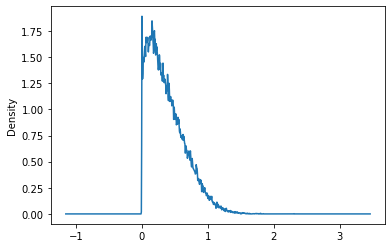

In [27]:
df_conv[116].plot.kde(0.01)

In [28]:
# always larger than or equal to zero

(df_conv < 0).sum().sum()

0

In [29]:
df_conv_true = df_conv.join(df_true, how="inner")
df_conv_true

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,ID,true,prediction
0,0.966398,0.259215,0.496319,0.829589,0.344971,0.152670,0.720227,0.123976,0.561715,0.145842,...,0.232208,0.526616,0.675230,0.223346,0.521280,0.677738,0.450698,8928_160,6,6
1,0.524723,0.228454,0.705758,1.030062,0.242494,0.159847,0.409182,0.338511,0.290713,0.317818,...,0.534085,0.604216,0.576146,0.129164,0.130303,0.485668,1.307134,8928_183,6,6
3,0.783375,0.118536,0.475350,1.022621,0.323562,0.108109,0.888962,0.225075,0.702394,0.334535,...,0.292180,1.042650,0.312549,0.133560,0.272857,0.833340,0.700633,8928_204B,6,6
5,0.312823,0.361250,0.346274,0.397543,0.036284,0.635172,0.204650,0.354629,0.096156,0.505859,...,0.570144,0.812607,0.084321,0.000000,0.511175,0.126112,0.035106,960_41,2,2
13,0.249385,0.344479,0.171947,0.692235,0.070903,0.534629,0.080226,0.009443,0.102379,0.472990,...,0.459562,0.729845,0.120973,0.027887,0.432335,0.113748,0.049171,1289_42,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50406,0.215191,0.030080,0.300008,0.278434,0.095246,0.714414,0.193977,0.064485,0.908448,0.118502,...,0.547007,0.191994,0.063492,0.052315,0.415422,0.425363,1.403822,105883_109B,8,8
50408,0.073903,0.252295,0.181150,0.102135,0.619642,0.796258,0.270251,0.089478,1.592569,0.274092,...,0.703301,0.403069,0.435249,0.547125,0.293374,1.396115,1.677838,115454_34E,9,9
50409,0.036732,0.611936,0.102694,0.049904,0.459895,0.291486,0.097040,0.055738,1.230726,0.237384,...,0.475897,0.469214,0.191125,0.680284,0.246726,0.572802,1.837968,115454_36B,9,9
50410,0.056509,0.634947,0.127518,0.124925,0.542559,0.402485,0.116800,0.049700,1.652613,0.145261,...,0.281986,0.658542,0.288947,0.544461,0.284441,1.177597,1.834320,115454_37A,9,9


In [30]:
max_fp = (df_conv == df_conv_true.max()).sum(axis=1)
max_fp = max_fp[max_fp > 0]
max_fp

5        1
112      1
362      1
745      1
1118     1
        ..
50194    1
50313    2
50319    1
50342    1
50349    3
Length: 438, dtype: int64

In [31]:
df_max = df_conv[df_conv.index.isin(max_fp.index)]
df_max

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
5,0.312823,0.361250,0.346274,0.397543,0.036284,0.635172,0.204650,0.354629,0.096156,0.505859,...,0.645015,0.331066,0.209530,0.570144,0.812607,0.084321,0.000000,0.511175,0.126112,0.035106
112,0.162510,0.084014,0.277335,0.111756,0.635640,0.597496,0.724420,0.452866,0.706931,0.324863,...,0.687655,0.344218,0.143150,1.050246,0.174882,0.367549,0.154290,0.479850,1.451486,0.251188
362,1.143195,1.791199,0.812952,0.117697,0.507098,0.237476,0.896663,0.350537,0.029787,0.132408,...,0.964825,1.178760,0.730691,0.411653,0.327501,0.220557,0.043390,0.194560,1.062954,0.140635
745,0.493104,0.766403,0.385513,0.267593,0.501709,0.533064,0.583267,0.104186,0.806727,0.107453,...,0.750995,0.641739,0.128126,0.768422,0.862316,0.588524,0.139796,0.301434,0.422272,1.051324
1118,1.237631,0.756213,0.500351,0.941053,0.260509,0.489918,0.804910,0.170239,0.618707,0.596520,...,0.068896,0.282493,0.562434,0.471858,0.413521,0.933123,0.180945,0.265120,0.508701,0.516615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50194,1.834471,0.213119,0.551113,0.982701,0.190511,0.433036,1.118971,0.264757,0.543528,0.125979,...,0.488094,0.127259,0.103389,0.499195,1.452786,0.824746,0.538949,0.177220,0.529748,0.976175
50313,0.059575,0.375897,0.081935,0.863243,0.253325,0.643309,0.351374,0.029617,0.108196,0.733560,...,0.350487,0.327100,0.732981,0.379992,0.840387,0.122512,0.044216,0.581839,1.203575,0.095184
50319,0.814018,0.371930,0.222497,0.245484,0.745612,0.632873,0.856598,0.214188,1.678445,0.096084,...,0.846600,0.408217,0.315524,0.631670,0.336970,0.444927,0.365152,0.116268,0.688696,0.646736
50342,1.346787,0.246397,0.108615,0.884496,0.164647,0.210833,1.055162,0.187409,0.158374,0.188872,...,0.196995,0.280133,0.199801,0.220110,1.257340,0.231762,0.277192,0.041728,0.602628,0.570968


# class activation

In [32]:
mean_activation = np.expand_dims(df_max.mean(), 1) * class_weights
mean_activation.shape

(512, 10)

In [33]:
mean_activation.mean(), mean_activation.std()

(3.2203774e-05, 0.073080674)

In [34]:
df_activ = df_max @ class_weights
df_activ

,0,1,2,3,4,5,6,7,8,9
5,-3.912421,-0.939461,6.877619,5.342638,5.224458,2.464270,2.510119,-4.514287,-6.726700,-8.059894
112,-6.806087,-1.676878,-2.040202,-1.438631,0.289952,-0.945284,1.907634,8.389852,8.162322,-3.785964
362,-8.052616,-6.744788,-6.621289,-3.650043,4.737135,1.257743,5.882541,11.984166,6.532068,-6.845848
745,-8.962079,-8.076782,-8.505241,-3.685071,-1.973145,-0.948905,5.501569,6.596615,11.904867,10.140631
1118,-6.195677,1.735599,3.501711,5.757783,4.820001,3.033207,4.158695,0.527030,-2.481493,-17.204227
...,...,...,...,...,...,...,...,...,...,...
50194,-5.167272,-3.955575,-3.437001,-1.668681,-0.462420,-2.011239,3.337521,12.342045,6.931334,-4.024634
50313,-6.614378,-4.442881,1.140024,3.729155,7.870792,4.563626,2.264752,0.765845,-2.367311,-4.473841
50319,-7.327973,-4.444510,-5.097042,-2.829128,-1.986956,1.928066,6.599341,11.328323,5.831076,-4.386482
50342,-5.385743,-6.242576,-5.605066,-4.076949,1.672375,3.485858,9.047443,12.557112,1.178668,-7.040256


In [1]:
df_activ.loc[df_true.true == 3]

NameError: name 'df_activ' is not defined

In [36]:
df_activ.loc[df_true.true == 7]

,0,1,2,3,4,5,6,7,8,9
112,-6.806087,-1.676878,-2.040202,-1.438631,0.289952,-0.945284,1.907634,8.389852,8.162322,-3.785964
362,-8.052616,-6.744788,-6.621289,-3.650043,4.737135,1.257743,5.882541,11.984166,6.532068,-6.845848
1211,-5.969807,-3.874276,-2.557679,-0.204983,4.078314,1.872087,5.077895,9.649700,3.935903,-11.349597
1229,-4.665176,-3.050113,-5.373076,-2.284757,-0.172128,3.149078,5.126607,8.348092,5.728878,-7.634101
2108,-5.731776,-5.045078,-3.380465,2.002277,2.885440,3.733888,5.410471,8.430489,3.887580,-13.060579
...,...,...,...,...,...,...,...,...,...,...
49654,-8.430721,-8.835489,-11.491343,-9.946054,-3.652831,3.556978,12.822056,14.958731,9.130987,-0.676699
49908,-8.236566,-6.026146,-5.844448,-5.066550,-1.595397,1.125362,4.318824,17.031742,11.912182,-4.381457
50194,-5.167272,-3.955575,-3.437001,-1.668681,-0.462420,-2.011239,3.337521,12.342045,6.931334,-4.024634
50319,-7.327973,-4.444510,-5.097042,-2.829128,-1.986956,1.928066,6.599341,11.328323,5.831076,-4.386482


In [37]:
df_activ.loc[df_activ[7].nlargest(10).index]

,0,1,2,3,4,5,6,7,8,9
38423,-11.340544,-7.483044,-9.962102,-11.893899,-8.256207,-4.761198,8.955301,22.774582,20.820574,-0.416336
44908,-11.714040,-9.167432,-11.192202,-10.552570,-8.178491,-1.861662,12.540983,21.293285,20.072529,1.156585
42580,-7.003762,-3.958913,-11.349788,-7.928437,-10.391247,-0.426242,8.325590,20.134760,12.201275,2.359181
39981,-9.446610,-3.545352,-5.200869,-5.645201,-3.706867,-1.343747,9.392708,20.015572,12.626796,-12.119620
36429,-8.176275,-4.340107,-7.235553,-10.131374,-8.167573,-0.804920,11.199661,19.759861,14.470572,-3.846339
47001,-6.726582,-2.820560,-2.998602,-6.579360,-3.363308,-0.264377,11.752166,19.397530,10.370953,-15.863377
33947,-13.114513,-6.493178,-8.834357,-1.049045,4.174829,7.331848,12.044146,19.297060,8.384109,-19.206787
28503,-8.003864,-5.045670,-4.230177,-7.085652,-2.499219,-0.930761,11.174770,18.766201,10.919762,-11.757246
26054,-9.650629,-8.509087,-12.315535,-11.809866,-12.144060,-3.654111,8.530642,18.706188,21.402220,8.133543
35866,-7.421494,-4.968049,-5.455999,-3.939951,-1.212723,1.850047,13.389046,18.681343,4.181987,-17.047663


In [38]:
(df_activ[7] - df_activ[6]).nlargest(10)

38423    13.819281
48179    13.473053
48178    13.315886
43800    13.297342
43804    13.297342
30725    12.936120
30792    12.714109
49908    12.712918
47271    12.631700
34523    12.261085
dtype: float32

# diff between the period and the just before

In [39]:
(df_activ[7] - df_activ[6]).loc[df_true.true == 7].nlargest(10)

38423    13.819281
48179    13.473053
48178    13.315886
43800    13.297342
43804    13.297342
30792    12.714109
49908    12.712918
34523    12.261085
42580    11.809170
28830    10.973568
dtype: float32

In [40]:
top_indexes = []
for i in range(10):
    top_indexes.append((df_activ[i] - df_activ[max(i-1,0)]).loc[df_true.true == i].nlargest(10).index)
top_indexes

[Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([5], dtype='int64'),
 Int64Index([39143, 34154, 5095, 5984, 19649, 34679, 37058, 27212, 12041,
             29730],
            dtype='int64'),
 Int64Index([17790, 20385, 17741, 17763, 17780, 43371, 33998, 15630, 4006,
             36025],
            dtype='int64'),
 Int64Index([49932, 27122, 10186, 21424, 47111, 31855, 17797, 32593, 16869,
             41410],
            dtype='int64'),
 Int64Index([31242, 47528, 47537, 47542, 26356, 26395, 50349, 5920, 6366,
             46154],
            dtype='int64'),
 Int64Index([38423, 48179, 48178, 43800, 43804, 30792, 49908, 34523, 42580,
             28830],
            dtype='int64'),
 Int64Index([48079, 44489, 42595, 42162, 47926, 41598, 48323, 21616, 41371,
             42319],
            dtype='int64'),
 Int64Index([47285, 21535, 28743, 28735, 46865, 48851, 48068, 45898, 44824,
             47123],
            dtype='int64')]

In [41]:
top_ids = []
for i in range(10):
    top_ids.append(
        df_true.ID[top_indexes[i]].tolist()
    )
top_ids[2] = []
top_ids

[[],
 [],
 [],
 ['4976_62',
  '5039_105',
  '199_86',
  '317_96',
  '10667_66',
  '5504_70',
  '5814_94',
  '2112_49_0',
  '959_89A',
  '2430_58'],
 ['7963_180B',
  '100754_163B',
  '2888_118A',
  '2893_118A',
  '7963_118A',
  '6338_162',
  '12685_172A',
  '2923_121',
  '108_168',
  '15045_109B'],
 ['106355_102',
  '2102_82',
  '1183_199',
  '2672_162',
  '16429_107',
  '8208_77',
  '2836_121',
  '2401_101',
  '3896_103',
  '6519_105'],
 ['10415_106A2',
  '23950_102',
  '23956_102',
  '23961_103',
  '8289_182',
  '10422_86',
  '15156_129',
  '9106_154',
  '3376_107B',
  '25022_77B'],
 ['25507_151',
  '104253_110D1',
  '104253_110D',
  '26013_109',
  '100995_109B',
  '25765_83B',
  '105202_119A',
  '13160_110C',
  '19189_198A',
  '26216_111C'],
 ['105024_113A',
  '105322_112C',
  '104895_109A',
  '104893_137B',
  '103531_82B',
  '105377_123',
  '103537_114B1',
  '104986_111F',
  '105812_128B',
  '103547_108A'],
 ['109468_111A1',
  '107330_82C',
  '115505_123A',
  '109215_123C',
  '10814

In [42]:
def read_from_csv(filepath, columns=False):
    if Path(filepath).is_file():

        with open(filepath, "r", newline="", encoding="utf-8-sig") as csvfile:
            listreader = csv.reader(csvfile)
            if columns:
                columns = next(listreader)
            readlist = list(listreader)

    else:
        columns = []
        readlist = []

    if columns:
        return columns, readlist
    else:
        return readlist


def write_to_csv(lines, filepath, columns=None):
    Path(filepath).parent.mkdir(parents=True, exist_ok=True)

    with open(filepath, "w", newline="", encoding="utf-8-sig") as csvfile:
        listwriter = csv.writer(csvfile)

        if columns is not None:
            listwriter.writerow(columns)

        for line in lines:
            listwriter.writerow(line)

In [43]:
write_to_csv(top_ids, "vgg_activation_top10.csv")
top_ids = read_from_csv("vgg_activation_top10.csv")
top_ids

[[],
 [],
 [],
 ['4976_62',
  '5039_105',
  '199_86',
  '317_96',
  '10667_66',
  '5504_70',
  '5814_94',
  '2112_49_0',
  '959_89A',
  '2430_58'],
 ['7963_180B',
  '100754_163B',
  '2888_118A',
  '2893_118A',
  '7963_118A',
  '6338_162',
  '12685_172A',
  '2923_121',
  '108_168',
  '15045_109B'],
 ['106355_102',
  '2102_82',
  '1183_199',
  '2672_162',
  '16429_107',
  '8208_77',
  '2836_121',
  '2401_101',
  '3896_103',
  '6519_105'],
 ['10415_106A2',
  '23950_102',
  '23956_102',
  '23961_103',
  '8289_182',
  '10422_86',
  '15156_129',
  '9106_154',
  '3376_107B',
  '25022_77B'],
 ['25507_151',
  '104253_110D1',
  '104253_110D',
  '26013_109',
  '100995_109B',
  '25765_83B',
  '105202_119A',
  '13160_110C',
  '19189_198A',
  '26216_111C'],
 ['105024_113A',
  '105322_112C',
  '104895_109A',
  '104893_137B',
  '103531_82B',
  '105377_123',
  '103537_114B1',
  '104986_111F',
  '105812_128B',
  '103547_108A'],
 ['109468_111A1',
  '107330_82C',
  '115505_123A',
  '109215_123C',
  '10814